In [1]:
import torch 

# train_data_client_1 = torch.load('./CIKM22Competition/1/train.pt')

train_data_client_path = ['./CIKM22Competition/' + str(i) + '/train.pt' for i in range(1,14)]
train_data_client_all = [torch.load(p) for p in train_data_client_path]
for i,d in enumerate(train_data_client_all):
    print('client: {},\t data: {}'.format(i,d[0]))

/cloud/fs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


client: 0,	 data: Data(x=[43, 22], edge_index=[2, 98], edge_attr=[98, 8], y=[1, 1], data_index=0)
client: 1,	 data: Data(x=[29, 20], edge_index=[2, 56], edge_attr=[56, 4], y=[1, 1], data_index=0)
client: 2,	 data: Data(x=[20, 37], edge_index=[2, 42], y=[1, 1], data_index=0)
client: 3,	 data: Data(x=[12, 7], edge_index=[2, 26], edge_attr=[26, 4], y=[1, 1], data_index=0)
client: 4,	 data: Data(x=[16, 18], edge_index=[2, 36], edge_attr=[36, 4], y=[1, 1], data_index=0)
client: 5,	 data: Data(x=[62, 22], edge_index=[2, 136], edge_attr=[136, 8], y=[1, 1], data_index=0)
client: 6,	 data: Data(x=[15, 38], edge_index=[2, 30], y=[1, 1], data_index=0)
client: 7,	 data: Data(x=[13, 19], edge_index=[2, 24], edge_attr=[24, 4], y=[1, 1], data_index=0)
client: 8,	 data: Data(x=[25, 28], edge_index=[2, 28], edge_attr=[28, 3], y=[1, 1], data_index=0)
client: 9,	 data: Data(x=[10, 6], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 10], data_index=0)
client: 10,	 data: Data(x=[18, 22], edge_index=[2, 38], e

In [4]:
train_data_client_all[0][0]

Data(x=[43, 22], edge_index=[2, 98], edge_attr=[98, 8], y=[1, 1], data_index=0)

In [9]:
import logging

import torch
import os
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

logger = logging.getLogger(__name__)

class CIKMCUPDataset(InMemoryDataset):
    name = 'CIKM22Competition'
    inmemory_data = {}

    def __init__(self, root):
        super(CIKMCUPDataset, self).__init__(root)

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.name)

    @property
    def processed_file_names(self):
        return ['pre_transform.pt', 'pre_filter.pt']

    def __len__(self):
        return len([
            x for x in os.listdir(self.processed_dir)
            if not x.startswith('pre')
        ])

    def _load(self, idx, split):
        try:
            data = torch.load(
                os.path.join(self.processed_dir, str(idx), f'{split}.pt'))
        except:
            data = None
        return data

    def process(self):
        pass

    def __getitem__(self, idx):
        if idx in self.inmemory_data:
            return self.inmemory_data[idx]
        else:
            self.inmemory_data[idx] = {}
            for split in ['train', 'val', 'test']:
                split_data = self._load(idx, split)
                if split_data:
                    self.inmemory_data[idx][split] = split_data
            return self.inmemory_data[idx]

def load_client_data(config):
    dataset = CIKMCUPDataset(config.root_path)

    data_dict = {}
    for client_id in range(1,len(dataset)):
        dataloader_dict = {}
        dataloader_dict['train'] = DataLoader(dataset[client_id]['train'],config.client.bs,shuffle=config.client.shuffle)
        dataloader_dict['val'] = DataLoader(dataset[client_id]['val'],config.client.bs,shuffle=config.client.shuffle)
        dataloader_dict['test'] = DataLoader(dataset[client_id]['test'],config.client.bs,shuffle=config.client.shuffle)
        data_dict[client_id] = dataloader_dict
    return data_dict


def load_cikmcup_data(config):
    from torch_geometric.loader import DataLoader

    # Build data
    logger.info(f'Loading CIKMCUP data from {os.path.abspath(os.path.join(config.data.root, "CIKM22Competition"))}.')
    dataset = CIKMCUPDataset(config.data.root)
    config.merge_from_list(['federate.client_num', len(dataset)])

    if len(dataset) == 0:
        raise FileNotFoundError(f'Cannot load CIKMCUP data from {os.path.abspath(os.path.join(config.data.root, "CIKM22Competition"))}, please check if the directory is correct.')

    data_dict = {}
    # Build DataLoader dict
    for client_idx in range(1, config.federate.client_num + 1):
        logger.info(f'Loading CIKMCUP data for Client #{client_idx}.')
        dataloader_dict = {}
        tmp_dataset = []
        if 'train' in dataset[client_idx]:
            dataloader_dict['train'] = DataLoader(dataset[client_idx]['train'],
                                                  config.data.batch_size,
                                                  shuffle=config.data.shuffle)
            tmp_dataset += dataset[client_idx]['train']
        if 'val' in dataset[client_idx]:
            dataloader_dict['val'] = DataLoader(dataset[client_idx]['val'],
                                                config.data.batch_size,
                                                shuffle=False)
            tmp_dataset += dataset[client_idx]['val']
        if 'test' in dataset[client_idx]:
            dataloader_dict['test'] = DataLoader(dataset[client_idx]['test'],
                                                 config.data.batch_size,
                                                 shuffle=False)
            tmp_dataset += dataset[client_idx]['test']
        if tmp_dataset:
            dataloader_dict['num_label'] = 0

        data_dict[client_idx] = dataloader_dict

    return data_dict


In [10]:
from yacs.config import CfgNode
config = CfgNode.load_cfg(open('./config.yaml'))


In [11]:
from yacs.config import CfgNode
config = CfgNode.load_cfg(open('./config.yaml'))

client_data = load_client_data(config)

client_data


{1: {'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f6845bc5e20>,
  'val': <torch_geometric.loader.dataloader.DataLoader at 0x7f6827e9b7f0>,
  'test': <torch_geometric.loader.dataloader.DataLoader at 0x7f684d7eba90>},
 2: {'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f68608ccfd0>,
  'val': <torch_geometric.loader.dataloader.DataLoader at 0x7f6818f3bdf0>,
  'test': <torch_geometric.loader.dataloader.DataLoader at 0x7f684a891250>},
 3: {'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f6818edb8e0>,
  'val': <torch_geometric.loader.dataloader.DataLoader at 0x7f6821d33d00>,
  'test': <torch_geometric.loader.dataloader.DataLoader at 0x7f68265c9d60>},
 4: {'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f68264462b0>,
  'val': <torch_geometric.loader.dataloader.DataLoader at 0x7f6826470cd0>,
  'test': <torch_geometric.loader.dataloader.DataLoader at 0x7f68265183d0>},
 5: {'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f68262

In [16]:
from model import GCN_C
Net = GCN_C(in_channels=22,out_channels=22,num_cls=2)
print(Net)

GCN_C(
  (feature): GCN_Net(
    (convs): ModuleList(
      (0): GCNConv(22, 64)
      (1): GCNConv(64, 22)
    )
  )
  (classfer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=22, out_features=2, bias=True)
  )
)


In [17]:
from model import GCN_Net
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_dl = client_data[1]['train']
val_dl = client_data[1]['val']

model.train()

def train(model,dl,optimizer,criterion):
    model.train()
    correct = 0
    losses = 0
    for i ,data in enumerate(dl):
        data = data.to(device)
        # print(data)
        optimizer.zero_grad()
        out = model(data)
        # print(out.shape)
        # print(data.y.shape)
        label = F.one_hot(data.y,num_classes=2).squeeze(1).float()
        # print(label.shape)
        loss = criterion(out,label)

        # 计算正确率和损失
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.squeeze(1)).sum())
        losses  += loss.item()
        # print(pred)
        # print(data.y.squeeze(1))
        loss.backward()
        optimizer.step()

    # print(len(dl.dataset))
    losses = loss/len(dl.dataset)
    acc = correct/len(dl.dataset)
    print('Train loss: {} acc: {}'.format(losses,acc))

def val(model,dl,criterion):
    model.eval()
    correct = 0
    losses = 0
    for i ,data in enumerate(dl):
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.squeeze(1)).sum())

        label = F.one_hot(data.y,num_classes=2).squeeze(1).float()
        loss = criterion(out,label)
        losses += loss.item()

    loss = loss/len(dl.dataset)
    acc = correct/len(dl.dataset)
    print('Val loss: {}\t acc: {}'.format(losses,acc))

for e in range(50):
    print(e)
    train(model,train_dl,optimizer,criterion)
    val(model,val_dl,criterion)
    # break

0
Train loss: 0.0005593191017396748 acc: 0.6108887109687751
Val loss: 4.454739451408386	 acc: 0.6442307692307693
1
Train loss: 0.00047380063915625215 acc: 0.6341072858286629
Val loss: 4.405001521110535	 acc: 0.6274038461538461
2
Train loss: 0.0004621165571734309 acc: 0.6285028022417934
Val loss: 4.385568559169769	 acc: 0.6442307692307693
3
Train loss: 0.00046317666419781744 acc: 0.6533226581265013
Val loss: 4.306357204914093	 acc: 0.6586538461538461
4
Train loss: 0.0003819582343567163 acc: 0.66693354683747
Val loss: 4.245070993900299	 acc: 0.6634615384615384
5
Train loss: 0.0005061901756562293 acc: 0.6661329063250601
Val loss: 4.30260843038559	 acc: 0.6682692307692307
6
Train loss: 0.0005067556630820036 acc: 0.6677341873498799
Val loss: 4.307313919067383	 acc: 0.65625
7
Train loss: 0.00040397068369202316 acc: 0.6797437950360288
Val loss: 4.094852030277252	 acc: 0.6658653846153846
8
Train loss: 0.0004884762456640601 acc: 0.6717373899119295
Val loss: 4.144801020622253	 acc: 0.66826923076

In [59]:
weight = model.state_dict()
for key,value in weight.items():
    print(key,value.shape)

conv1.bias torch.Size([64])
conv1.lin.weight torch.Size([64, 22])
conv2.bias torch.Size([64])
conv2.lin.weight torch.Size([64, 64])
conv3.bias torch.Size([64])
conv3.lin.weight torch.Size([64, 64])
lin.weight torch.Size([2, 64])
lin.bias torch.Size([2])


In [62]:
class GCN_R(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_cls,
                 max_depth=2,
                 hidden=64,
                 drop_out=0.2
                 ):
        super(GCN_R, self).__init__()
        self.feature = GCN_Net(in_channels=in_channels,out_channels=out_channels,hidden=hidden,max_depth=max_depth)
        self.classfer = nn.Sequential(
                        nn.Dropout(drop_out),
                        nn.Linear(out_channels,num_cls)
        )
    
    def forward(self,data):
        x = self.feature(data)
        x = global_mean_pool(x,batch=data.batch)
        x = self.classfer(x)
        return x

Net = GCN_R(in_channels=6,out_channels=6,num_cls=10)
print(Net)

GCN_R(
  (feature): GCN_Net(
    (convs): ModuleList(
      (0): GCNConv(6, 64)
      (1): GCNConv(64, 6)
    )
  )
  (classfer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6, out_features=10, bias=True)
  )
)


In [ ]:
from model import GCN_Net
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
train_dl = client_data[1]['train']
val_dl = client_data[1]['val']

model.train()

def train(model,dl,optimizer,criterion):
    model.train()
    correct = 0
    losses = 0
    for i ,data in enumerate(dl):
        data = data.to(device)
        # print(data)
        optimizer.zero_grad()
        out = model(data)
        # print(out.shape)
        # print(data.y.shape)
        label = out
        print(label.shape)
        loss = criterion(out,label)

        # 计算正确率和损失
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.squeeze(1)).sum())
        losses  += loss.item()
        # print(pred)
        # print(data.y.squeeze(1))
        loss.backward()
        optimizer.step()

    # print(len(dl.dataset))
    losses = loss/len(dl.dataset)
    acc = correct/len(dl.dataset)
    print('Train loss: {} acc: {}'.format(losses,acc))

def val(model,dl,criterion):
    model.eval()
    correct = 0
    losses = 0
    for i ,data in enumerate(dl):
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.squeeze(1)).sum())

        label = F.one_hot(data.y,num_classes=2).squeeze(1).float()
        loss = criterion(out,label)
        losses += loss.item()

    loss = loss/len(dl.dataset)
    acc = correct/len(dl.dataset)
    print('Val loss: {}\t acc: {}'.format(losses,acc))

for e in range(50):
    print(e)
    train(model,train_dl,optimizer,criterion)
    val(model,val_dl,criterion)

In [57]:
train_dl = client_data[10]['train'].dataset[0]
val_dl = client_data[10]['val'].dataset[0]

Data(x=[10, 6], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 10], data_index=0)

{0: Text(0.005634872040700612, 0.3659868674731632, '0'),
 1: Text(0.21634556696975188, 0.24484773067114587, '1'),
 2: Text(0.36857970724607375, 0.14229435523870962, '2'),
 3: Text(0.34575899637716206, -0.06058382255382578, '3'),
 4: Text(0.2353808466476482, -0.5359040272194069, '4'),
 5: Text(-0.4467103481071986, -0.8580417484210131, '5'),
 6: Text(0.045685234344382895, 0.2666529619141564, '6'),
 7: Text(0.22910037072523712, -0.09195034486076574, '7'),
 8: Text(-0.5790650475595681, 0.44780660200689515, '8'),
 9: Text(-0.3975742783150868, 0.4527148185716103, '9'),
 10: Text(-1.0, 0.40589768944805005, '10'),
 11: Text(0.14779601081443883, 0.03611482971273302, '11'),
 12: Text(0.440596640533789, -0.023544318372328444, '12'),
 13: Text(0.3271868572047082, 0.11012545057848125, '13'),
 14: Text(0.5636873870429201, 0.21198058883642598, '14'),
 15: Text(0.3449297348849478, -0.3846657212604839, '15'),
 16: Text(-0.20905388029157476, -0.7673131707632234, '16'),
 17: Text(0.17140718963315169, 0.3

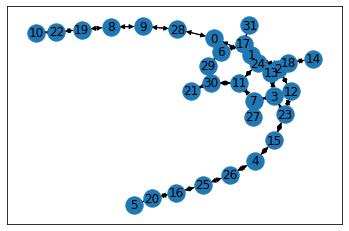

In [5]:
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx
import networkx as nx

fig = plt.figure(1)
graph = to_networkx(train_data_client_all[0][1])
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)
